<img src="../../../images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="left">

## _*A Monty Hall Problem Solver*_ 

The latest version of this notebook is available on https://github.com/qiskit/qiskit-tutorial.

For more information about how to use the IBM Q experience (QX), consult the [tutorials](https://quantumexperience.ng.bluemix.net/qstage/#/tutorial?sectionId=c59b3710b928891a1420190148a72cce&pageIndex=0), or check out the [community](https://quantumexperience.ng.bluemix.net/qstage/#/community).

***
### Contributors
Pierre Decoodt, Université Libre de Bruxelles

In [1]:
# useful additional packages 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import time
from pprint import pprint

# importing Qiskit
from qiskit import Aer, IBMQ
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.tools.visualization import plot_histogram

In [2]:
IBMQ.load_accounts()

## Introduction
The Monty Hall problem has been approached by various formulations related to quantum game theory (notably Fittney and Abbott 2002, D'Ariano et al., 2002). It is no wonder that Alice and Bob come now on stage, the first as the game master, the second as the player.

In this tutorial, a quantum model of the Monty Hall's game adapted for the ibmqx5 architecture will be built in three phases.

To begin, a circuit comprising two sets of three qubits entangled in a state W will be used to materialize the actions of Alice and Bob and tested in a simulation of the game.

In a second step, three Toffoli gates will be added to this circuit to establish a solution in which the measurement of a single qubit a sufficient number of run will be enough to determine the chances of gain Bob according to whether he prefers to stick with his first intention or switch.

In a final step, Bob's mood for sticking or switching will gradually change from one experiment to the next to see how this can modify his probability of winning.

Let's start by choosing the backend first. A simulator is always preferable during the first tests.

In [3]:
#can be very slow when number of shoots increases
backend = Aer.get_backend('qasm_simulator') 

# using IBMQ
# backend = IBMQ.get_backend('ibmq_qasm_simulator') 

print("Your choice for the backend is: ", backend.name())

Your choice for the backend is:  ibmq_qasm_simulator


## The  game circuit

The first circuit presented here established first two W states with the help of the $ F $ gates described in the tutorial "W State 1 - Multi-Qubit Systems". These W states serve as true random number generators.

The first W state involving the qubits $q_l$, $q_c$ and $q_r$ represents Alice's choice of the door behind which to hide the car (in the following two equations, the subscrits $l$, $c$ and $r$ represents respectively the left, center and right door):

$$ |W \rangle \:=\:\frac{1}{\sqrt{3}} \: (|1_l 0_c 0_r \rangle \: + \: |0_l 1_c 0_r\rangle \: +\:  |0_l 0_c 1_r\rangle) $$

The second W state involving the qubits $q_l^{*}$, $q_c^{*}$ and $q_r^{*}$ represents Bob's initial choice regarding the door behind which the car would hide:

$$ |W^{*} \rangle \: =\: \frac{1}{\sqrt{3}} \: (|1_{l}^{*} 0_{c}^{*} 0_{r}^{*} \rangle \: + \: |0_{l}^{*} 1_{c}^{*} 0_{r}^{*}\rangle \: +\:  |0_{l}^{*} 0_{c}^{*} 1_{r}^{*}\rangle) $$



A second true random number generator uses a two-qubit state to simulate coin tossing:

$$ H^{\otimes 2}|0_{a}0_{b}\rangle=|+_{a}\rangle \:|+_{b}\rangle=\frac{|0_{a}\rangle|0_{b}\rangle+|0_{a}\rangle|1_{b}\rangle+|1_{a}\rangle|0_{b}\rangle+|1_{a}\rangle|1_{b}\rangle}{2}$$

As explained in the tutorial "W State 2 - Let's Make a Deal", its role is to simulate Alice's choice of the door to open between two doors hiding a goat, when necessary.

A last circuit establishes a flag $q_s$ representing Bob's decision to stick with his initial choice (ground state) or to switch (excited state). A Hadamard gate applied to $q_s$  ensures the equiprobability of these possibilities.


In [4]:
# Define a F_gate
def F_gate(circ,q,i,j,n,k) :
    theta = np.arccos(np.sqrt(1/(n-k+1)))
    circ.ry(-theta,q[j])       
    circ.cz(q[i],q[j])
    circ.ry(theta,q[j])
    circ.barrier(q[i])
# Define the cxrv gate which uses reverse CNOT instead of CNOT
def  cxrv(circ,q,i,j) :
    circ.h(q[i])
    circ.h(q[j])
    circ.cx(q[j],q[i])
    circ.h(q[i])
    circ.h(q[j])
    circ.barrier(q[i],q[j])

In [5]:
# create quantum register
q = QuantumRegister(16)
# create classical register
c = ClassicalRegister(16)
# create quantim circuit
twin = QuantumCircuit(q, c)

In [6]:
# First W state
twin.x(q[14])
F_gate(twin,q,14,3,3,1)
F_gate(twin,q,3,2,3,2)
twin.cx(q[3],q[14])
twin.cx(q[2],q[3])

#Second W state
twin.x(q[12])
F_gate(twin,q,12,5,3,1)
F_gate(twin,q,5,6,3,2)
cxrv(twin,q,5,12)
twin.cx(q[6],q[5])

#Coin tossing
twin.h(q[0])
twin.h(q[1])

switch1 = QuantumCircuit(q, c, name='switch1')
#Stick or switch
switch1.h(q[13])

for i in range (4) :
    switch1.measure(q[i] , c[i]);
for i in range (5,7) :
    switch1.measure(q[i] , c[i]);
for i in range (12,15) :
    switch1.measure(q[i] , c[i]);

## Alice and Bob playing

Now we're going to watch Alice and Bob in their re-enactment of the TV show "Let's Make a Deal".

Among the possible scenarios, the one selected is obtained by a one shot execution of the addition of the two circuits described above.

Note that a virtual referee checks if one and only one car has been hidden by Alice and if Bob first chooses one and only one door. The program is rerun until a consistent result is achieved. This verification is only useful on real quantum computer.

From the result of the measurements of the nine qubits involved, the match is reconstituted on a conventional computer.

In [7]:
# create AliceBob circuit
AliceBob = twin+switch1

Label = ["left", "central", "right"]
wstates = 0

while wstates != 1:
    time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
    print("Alice vs Bob", "backend=", backend, "starting time", time_exp)
    result = execute(AliceBob, backend=backend, shots=1)
    time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
    print("Alice vs Bob", "backend=", backend, "     end time", time_exp)
    
    cstr = str(result.result().get_counts(AliceBob))
    nb_of_cars = int(cstr[3]) + int(cstr[14]) + int(cstr[15])
    nb_of_doors = int(cstr[12]) + int(cstr[11]) + int(cstr[5])
    wstates = nb_of_cars * nb_of_doors

print(" ")
print('Alice:       One car and two goats are now hidden behind these doors.')
print('             Which door do you choose?')
print(" ")

"Chosing the left door"
if int(cstr[5]) == 1:
    Doorchosen = 1

"Chosing the center door"
if int(cstr[11]) == 1:   
    Doorchosen = 2
    
"Chosing the right door"
if int(cstr[12]) == 1:
    Doorchosen = 3

time.sleep(2)    
print('Bob:         My choice is the',Label[Doorchosen-1], "door")
print(" ")

randomnb = int(cstr[16]) + int(cstr[17]) %2

if cstr[3] == "1":    #car behind left door 
    Doorwinning = 1
    if Doorchosen == 1: 
        Dooropen = 2 + randomnb
        Doorswitch = 3 - randomnb
    if Doorchosen == 2:
        Dooropen = 3 
        Doorswitch = 1
    if Doorchosen == 3:
        Dooropen = 2
        Doorswitch = 1    
               
if cstr[14] == "1":     #car behind central door 
    Doorwinning = 2
    if Doorchosen == 2:
        Dooropen = 1 + 2*randomnb 
        Doorswitch = 3 - 2*randomnb 
    if Doorchosen == 1: 
        Dooropen = 3
        Doorswitch = 2
    if Doorchosen == 3:   
        Dooropen = 1
        Doorswitch = 2
        
if cstr[15] == "1":     #car behind right door 
    Doorwinning = 3
    if Doorchosen == 3:
        Dooropen = randomnb + 1
        Doorswitch = 2 - randomnb
    if Doorchosen == 1: 
        Dooropen = 2
        Doorswitch = 3
    if Doorchosen == 2:   
        Dooropen = 1
        Doorswitch = 3
        
time.sleep(2)           
print('Alice:       Now I open the', Label[Dooropen-1], 'door and you see a goat')
time.sleep(2)
print('             You get an opportunity to change your choice!')
time.sleep(2)
print('             Do you want to switch for the',Label[Doorswitch-1], "door?")
print(" ")
time.sleep(2)

switch_flag = int(cstr[4])
    
"BOB STICKS WITH HIS FIRST CHOICE!"
if switch_flag == 0:
    Doorfinal = Doorchosen
    print('Bob:         I stick with my first choice, the',Label[Doorfinal-1], "door")
                
"BOB CHANGES HIS MIND!"
if switch_flag == 1:
    Doorfinal = Doorswitch
    print('Bob:         I change my mind and choose the',Label[Doorfinal-1], "door")

"FINAL ANNOUNCE"
if Doorfinal == Doorwinning:
    endmessage = 'won the car! Congratulations!'
else:
    endmessage = 'won a goat! Sorry!'

time.sleep(2)
print()
print('Alice:       You opened the',Label[Doorfinal-1],'door and', endmessage)
    
print("Game over")

Alice vs Bob backend= ibmq_qasm_simulator starting time 09/10/2018 10:03:06
Alice vs Bob backend= ibmq_qasm_simulator      end time 09/10/2018 10:03:06
 
Alice:       One car and two goats are now hidden behind these doors.
             Which door do you choose?
 
Bob:         My choice is the left door
 
Alice:       Now I open the central door and you see a goat
             You get an opportunity to change your choice!
             Do you want to switch for the right door?
 
Bob:         I change my mind and choose the right door

Alice:       You opened the right door and won the car! Congratulations!
Game over


## Toffoli is called on

One could claim that during this match the quantum computer plays against itself. However, it should be noted that, in the initial phase, it could have been used repetitively rather than in a single run, for the successive determination of $|W \rangle$, $|W^{*} \rangle$, coin tossing and the switch flag.

Similarly, two quantum computers such as ibmqx2 and ibmqx4 could have been used, one attributed to Alice and the other to Bob.

To take the step towards the quantum computer playing against itself autonomously and keeping track of the result, we need a circuit extension.

Here we use three Toffoli gates who have as a common target a qubit $q_w$.  When $q_w$ is in excited state, it indicates the victory of Bob .

The description of a Toffoli $C3$ gate is available in the "Quantum gates and linear algebra" Jupyter notebook of the Qiskit tutorial.

The following three operations are performed$^1$: 

Left door: $$C3\;(q_{l},\;q^{*}_{l},\;q_w)$$
Central door: $$C3\;(q_{c},\;q^{*}_{c},\;q_w)$$
Right door: $$C3\;(q_{r},\;q^{*}_{r},\;q_w)$$

The end result is that $q_w$ is in excited state iff either $q_{l}=q^{*}_{l}$ or $q_{c}=q^{*}_{c}$ or $q_{r}=q^{*}_{r}$.

$^1$ The order of these operations does not matter but is dictated by the architecture of the quantum computer and the $SWAP$ gates needed.

In [8]:
#Toffoli gates
Toffoli = QuantumCircuit(q, c, name='Toffoli')
Toffoli.ccx(q[3], q[5], q[4])
Toffoli.swap(q[2],q[3])
Toffoli.swap(q[6],q[5])
Toffoli.ccx(q[3], q[5], q[4])
Toffoli.swap(q[3],q[14])
Toffoli.swap(q[12],q[5])
Toffoli.ccx(q[3], q[5], q[4])

## A general solution where chance leads the game

The addition of the $C3$ gates and a last $cNOT$ gate with $q_s$ as control and $q_w$ as target makes it possible to determine experimentally the probability of winning for systematic sticking and systematic switching strategies. It suffices to measure $q_s$ and $q_w$ a sufficient number of shots.

Indeed, for Bob, switching is enough to turn a defeat into a victory and vice versa. 

Let's look at the results of this experiment.

ibmq_qasm_simulator shots 1024 starting time 09/10/2018 09:46:52
ibmq_qasm_simulator shots 1024 end time 09/10/2018 09:46:52


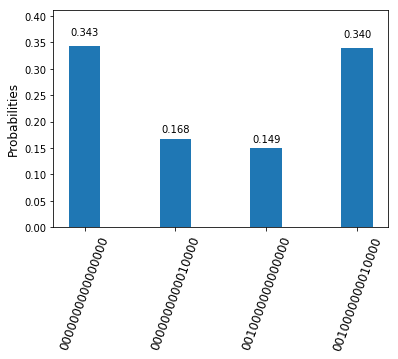

{'0000000000000000': 351, '0000000000010000': 172, '0010000000010000': 348, '0010000000000000': 153}
Proportion sticking:   0.51 
Proportion switching:   0.49 
Proportion winning when sticking:    0.33 
Proportion winning when switching:   0.69 


In [11]:
# A general solution with 50% switching strategy
switch_fifty_percent =QuantumCircuit(q,c, name='switch_fifty_percent')
#switch flag
switch_fifty_percent.h(q[13])
switch_fifty_percent.cx(q[13],q[4])
switch_fifty_percent.measure(q[4] , c[4]);
switch_fifty_percent.measure(q[13] , c[13]);
general_solution = twin+Toffoli+switch_fifty_percent

shots = 1024
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print(backend, "shots",  shots, "starting time", time_exp)
result = execute(general_solution, backend=backend, shots=shots)
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print(backend, "shots",  shots, "end time", time_exp)
plot_histogram(result.result().get_counts(general_solution))
print(result.result().get_counts(general_solution))
observable_stickwon =  {'0000000000010000': 1, '0010000000010000': 0, '0010000000000000': 0, '0000000000000000': 0}
observable_switchwon = {'0000000000010000': 0, '0010000000010000': 1, '0010000000000000': 0, '0000000000000000': 0}
observable_stickall =  {'0000000000010000': 1, '0010000000010000': 0, '0010000000000000': 0, '0000000000000000': 1}
observable_switchall = {'0000000000010000': 0, '0010000000010000': 1, '0010000000000000': 1, '0000000000000000': 0}
stickwon = result.result().average_data(general_solution,observable_stickwon)
switchwon = result.result().average_data(general_solution,observable_switchwon)
stickall = result.result().average_data(general_solution,observable_stickall)
switchall = result.result().average_data(general_solution,observable_switchall)
print("Proportion sticking: %6.2f " % stickall)
print("Proportion switching: %6.2f " % switchall)
stickwon_stickall = stickwon/stickall
switchwon_switchall = switchwon/switchall
print("Proportion winning when sticking:  %6.2f " % stickwon_stickall)
print("Proportion winning when switching: %6.2f " % switchwon_switchall)

## The Mood of Bob

After this experimental demonstration of the superiority of the strategy of systematic switching on systematic sticking, in agreement with a theory that is highly counterintuitive but certainly mathematically correct and generally accepted, one could consider that all is said and done.

However, it has not been experimentally demonstrated in this tutorial that there is not yet a better strategy between these two extremes. In order to reach a final conclusion, a series of experiments will follow, in which a gradual variation of the switch probability $P(s)$ is created. This equates to a gradual change in Bob's mood, from a propensity to stick with his first choice to an impetuous need to change his mind when given the opportunity.

To do this, the qubit $q_s$ undergoes an incremental rotation around X-axis $R_x(\lambda)$, according to the formula:

$$\lambda = 2\arcsin \sqrt{P(s)}$$

Since the circuit is  completed by a $cNOT$ gate with $q_s$ as control and $q_w$ as target, the  measure of $q_w$ alone is sufficient to estimate the probability that Bob will win for a given propensity to switch.

Here are the results of eight experiments with incremental values of $P(s)$, each with a sufficient number of shots.

ibmq_qasm_simulator shots 1024 starting time 09/10/2018 09:47:52
<qiskit._quantumcircuit.QuantumCircuit object at 0x000001D6CF93E7F0>  Proportion switching:  0.000   Proportion winning:   0.33
<qiskit._quantumcircuit.QuantumCircuit object at 0x000001D6CF8E2400>  Proportion switching:  0.125   Proportion winning:   0.38
<qiskit._quantumcircuit.QuantumCircuit object at 0x000001D6CF8E2588>  Proportion switching:  0.250   Proportion winning:   0.41
<qiskit._quantumcircuit.QuantumCircuit object at 0x000001D6CF8DF7B8>  Proportion switching:  0.375   Proportion winning:   0.46
<qiskit._quantumcircuit.QuantumCircuit object at 0x000001D6CF911278>  Proportion switching:  0.500   Proportion winning:   0.50
<qiskit._quantumcircuit.QuantumCircuit object at 0x000001D6CF821358>  Proportion switching:  0.625   Proportion winning:   0.53
<qiskit._quantumcircuit.QuantumCircuit object at 0x000001D6CF82DF98>  Proportion switching:  0.750   Proportion winning:   0.58
<qiskit._quantumcircuit.QuantumCircuit 

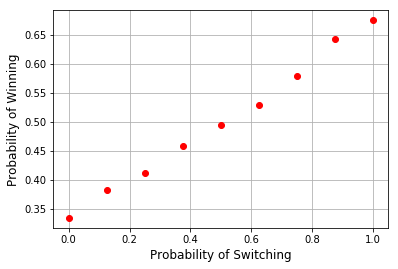

Our Advice: 

                  Thou Shalt Not Stick


In [12]:
# Illustrating different strategies
xdat = []
ydat = []
observable = {'0000000000000000': 0, '0000000000010000': 1}
shots = 1024
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print(backend, "shots",  shots, "starting time", time_exp)

for i in range(9) :
    strategies = QuantumCircuit(q, c, name='strategies')
    Prob = i/8
    lambda_s = 2*np.arcsin(np.sqrt(Prob))
    strategies.rx(lambda_s,q[13])
    strategies.cx(q[13],q[4])
    strategies.measure(q[4] , c[4]);
    statploti = "statplot"+str(i)
    statploti = QuantumCircuit(q,c, name=statploti)
    statploti = twin+Toffoli+strategies
    result = execute(statploti, backend=backend, shots=shots)
    loop_average=(result.result().average_data(statploti,observable))
    print(statploti," Proportion switching: %6.3f" % Prob, "  Proportion winning: %6.2f" % loop_average)
    ydat.append(loop_average)
    xdat.append(Prob)
    
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print(backend, "shots",  shots, "end time", time_exp)   
plt.plot(xdat, ydat, 'ro')
plt.grid()
plt.ylabel('Probability of Winning', fontsize=12)
plt.xlabel(r'Probability of Switching', fontsize=12)
plt.show()
print("Our Advice: \n")
y_aver = []
for j in range(0,7,3) :
    y_aver.append((ydat[j] + ydat[j+1] +ydat[j+2])/3)

if y_aver[0] == max(y_aver) :
    print("                  Thou Shalt Not Switch") 

elif y_aver[2] == max(y_aver) :
    print("                  Thou Shalt Not Stick")
    
else:
    print("          Just follow the intuition of the moment")  

## Concluding remarks:

The model presented here is a stand alone solution to the Monty Hall problem. All scenarios of the game remain in the realm of possibility as long as a measurement is not performed.

This model is further characterized by the use of multi-qubit gates. A circuit portion that creates a W state can be considered in its entirety as a three-qubit gate, which could be coined a $W$ gate. In the present case, two $W$ gates followed by three $C3$ gates make it possible to carry out the circuit.

The Monty Hall problem has a well-known classical solution, but nothing prevents us from imagining that this approach may be useful for certain problems for which a solution is impossible to achieve within a reasonable time by the conventional means of numerical calculation.